In [57]:
import pandas as pd

df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

df.sort_values(['Subject_ID', 'Month'], inplace=True)

# Create the target variable by shifting Hb column backward by 1 month for each patient
df['Next_Hb'] = df.groupby('Subject_ID')['Hb (g/dL)'].shift(-1)
df['Hb_diff'] = df['Hb (g/dL)'] - df.groupby('Subject_ID')['Hb (g/dL)'].shift(1)

df['Risk_Label'] = df['Next_Hb'].apply(lambda x: 1 if x < 10 or x > 12 else 0)


df = df.dropna(subset=['Next_Hb', 'Risk_Label', 'Hb_diff'])

feature_cols = [
    'Albumin (g/L)', 'BU - post HD', 'BU - pre HD', 'S Ca (mmol/L)',
    'SCR- post HD (µmol/L)', 'SCR- pre HD (µmol/L)',
    'Serum K Post-HD (mmol/L)', 'Serum K Pre-HD (mmol/L)',
    'Serum Na Pre-HD (mmol/L)', 'UA (mg/dL)', 'Hb (g/dL)', 'Hb_diff'
]

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']

X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

AUC Score: 0.67


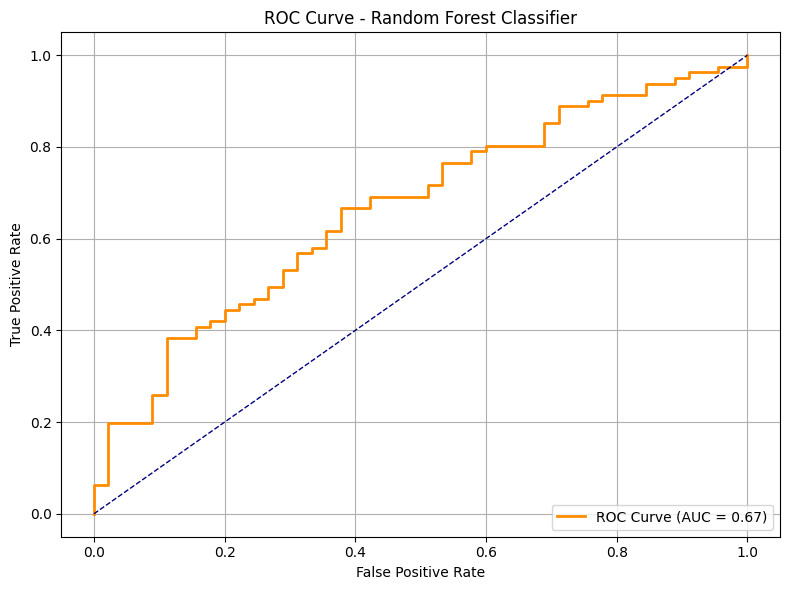

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier(random_state=42, class_weight='balanced', min_samples_split=3,n_estimators=100, max_depth=100, min_samples_leaf=1)
clf.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

y_test_proba = clf.predict_proba(X_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:03:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC Score: 0.68


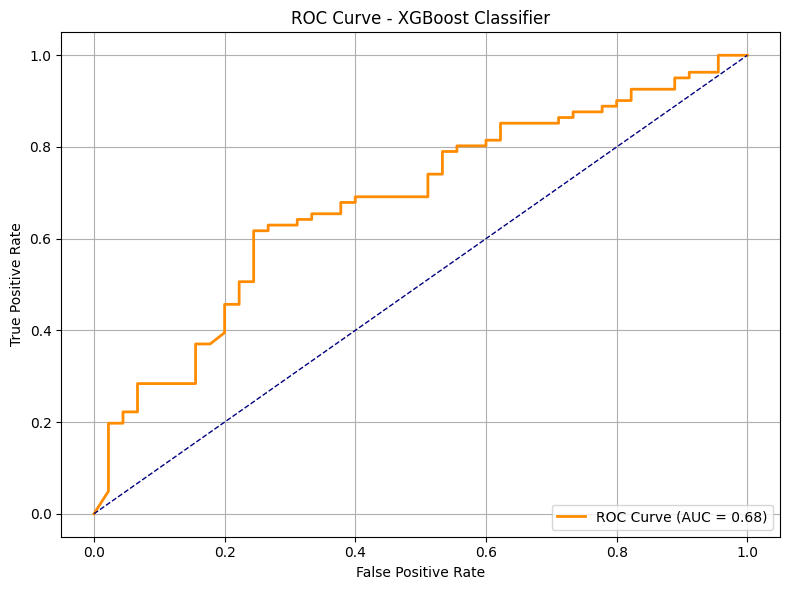

In [59]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix

# Compute sample weights for class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# XGBoost classifier with manually specified hyperparameters
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()


AUC Score: 0.51


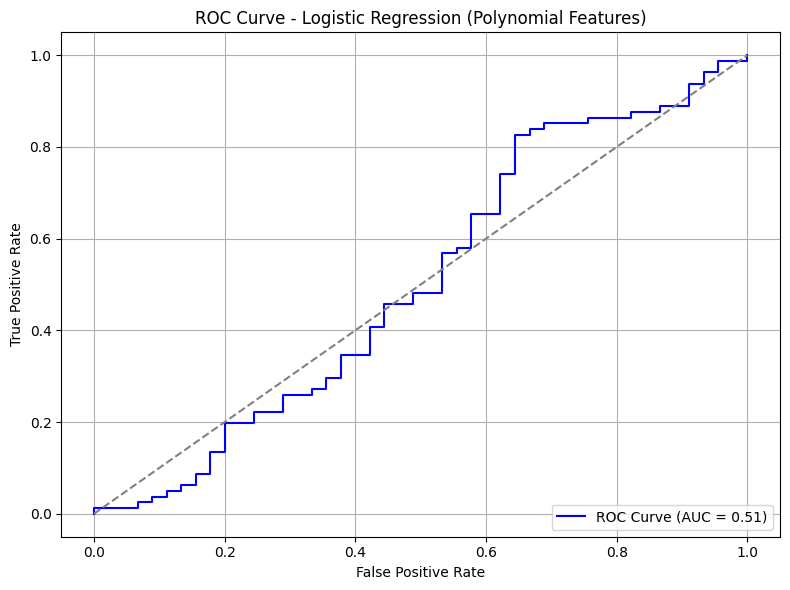

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    classification_report, accuracy_score,confusion_matrix,
    roc_curve, auc, RocCurveDisplay, roc_auc_score
)
import matplotlib.pyplot as plt

logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, interaction_only=False)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=100, random_state=42))
])

# Fit and predict
logreg_pipeline.fit(X_train, y_train)

y_test_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")
# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Polynomial Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
# Align test set columns (very important if feature order might've changed)
X_test = X_test[X_train.columns]

# ----- Random Forest -----
rf_proba = clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
rf_auc = roc_auc_score(y_test, rf_proba)


# ----- Logistic Regression -----
logreg_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_proba)
logreg_auc = roc_auc_score(y_test, logreg_proba)



In [64]:
# ----- XGBoost -----
# Ensure it's binary classification
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']

X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_binary_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)
xgb_binary_model.fit(X_train, y_train, sample_weight=sample_weights)
xgb_proba = xgb_binary_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_proba)
xgb_auc = roc_auc_score(y_test, xgb_proba)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:04:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


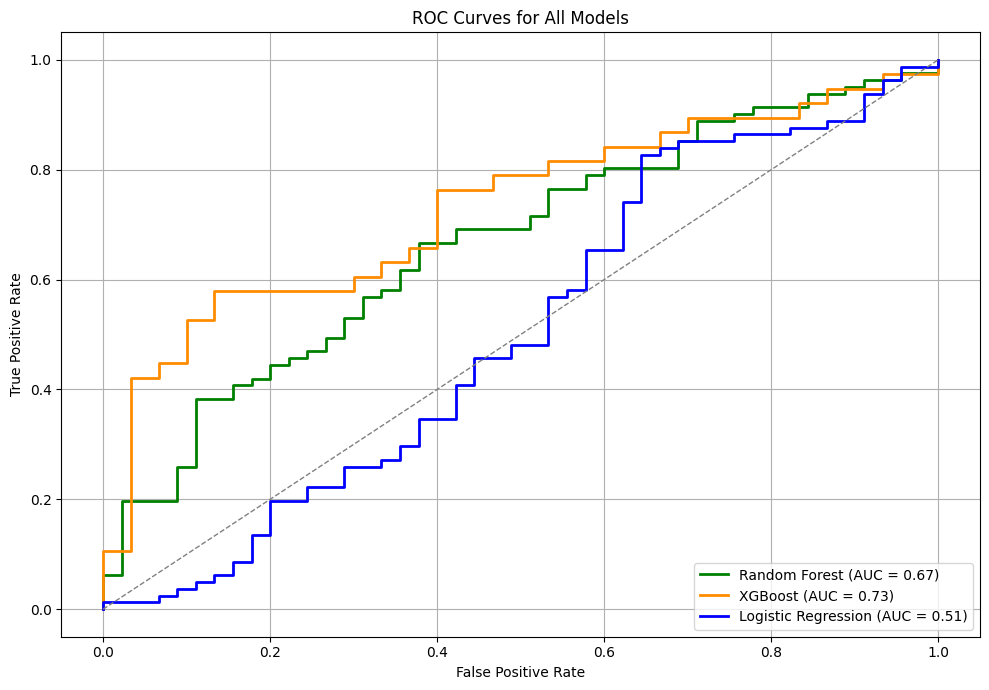

In [65]:
# ----- Plotting -----
plt.figure(figsize=(10, 7))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green', lw=2)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='darkorange', lw=2)
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})', color='blue', lw=2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()